In [1]:
import os
import warnings
from dotenv import load_dotenv
warnings.filterwarnings('ignore')
load_dotenv()

True

In [2]:
from haystack import Pipeline
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

## Indexing Documents Pipeline

In [3]:
document_store = InMemoryDocumentStore()

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = CohereDocumentEmbedder(model ="embed-english-v3.0")
writer = DocumentWriter(document_store=document_store)

In [4]:
indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter.documents", "embedder.documents")
indexing.connect("embedder.documents", "writer.documents")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: CohereDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

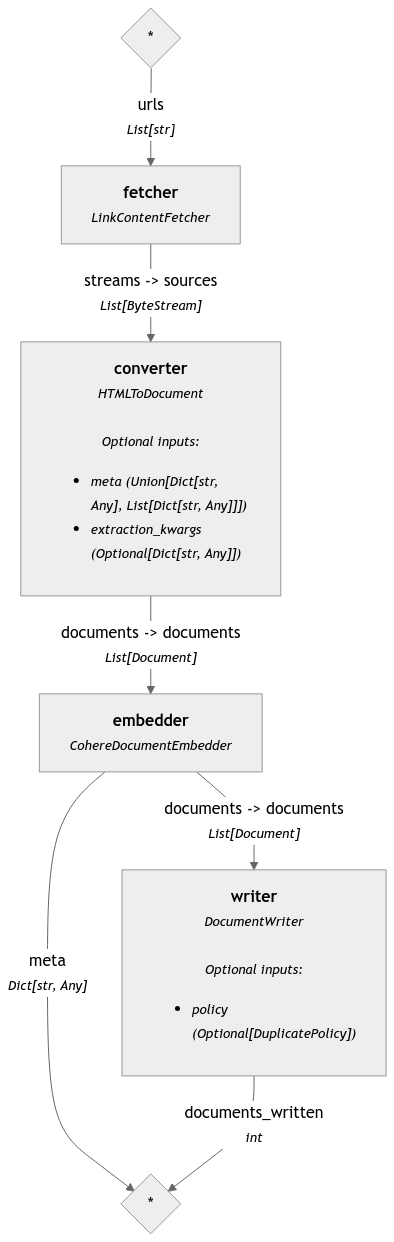

In [5]:
indexing.show()

In [6]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
            ]
        }
    }
)

Calculating embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=2032.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=[])},
 'writer': {'documents_written': 4}}

In [7]:
document_store.filter_documents()[0]

Document(id=e702fd349c9d5dbb355d2554bc03fd9bc867294c5a810c201dae29fc631eb7f7, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Haystack 2.0
You can use Coher...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere'}, embedding: vector of size 1024)

## Retreiveal Augmented Generation

In [8]:
prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""

## Pipeline

In [11]:
query_embedder = CohereTextEmbedder(model = "embed-english-v3.0")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
llm = OpenAIGenerator(api_key = Secret.from_env_var("GROQ_API_KEY"),
                      api_base_url = "https://api.groq.com/openai/v1",
                      model="llama3-8b-8192",
                      generation_kwargs = {"max_tokens": 512}                      
                      )

In [12]:
rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("llm", llm)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt","llm.prompt")

🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

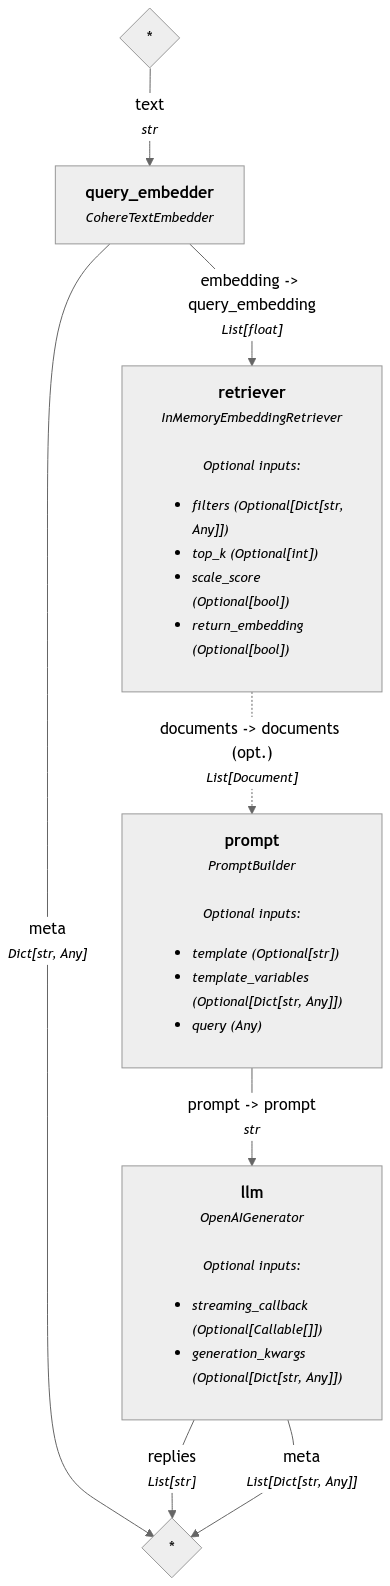

In [13]:
rag.show()

In [14]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["llm"]["replies"][0])

According to the provided context, you can use Cohere with Haystack in the following ways:

1. **Embedding Models**: Use CohereTextEmbedder or CohereDocumentEmbedder to leverage Embed v2 or v3 models for semantic embeddings in your indexing pipeline.

Example:
```
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("embedder", CohereDocumentEmbedder(model="embed-multilingual-v3.0", input_type="search_document"))
```

2. **Generative Models (LLMs)**: Use CohereGenerator to generate text based on a prompt and a given context.

Example:
```
from haystack_integrations.components.generators.cohere import CohereGenerator
pipe = Pipeline()
pipe.add_component("llm", CohereGenerator(model="command-light"))
```

3. **Ranker Models**: Use CohereRanker to rank documents based on their semantic relevance to a specified query.

Example:
```
from haystack_integrations.components.rankers.cohere import Coher

## Customize RAG

In [15]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }} 
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""



In [16]:
query_embedder = CohereTextEmbedder(model="embed-english-v3.0")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
llm = OpenAIGenerator(api_key = Secret.from_env_var("GROQ_API_KEY"),
                      api_base_url = "https://api.groq.com/openai/v1",
                      model="llama3-8b-8192",
                      generation_kwargs = {"max_tokens": 512}                      
                      )

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", llm)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

In [20]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "Hindi"},
    }
)

print(result["generator"]["replies"][0])

हायस्टैक में कोहीर का उपयोग करने के लिए, आप निम्न तरीके से कर सकते हैं:

1. Integration: Cohere - हायस्टैक 2.0 में, आप कोहीर embedding मॉडल, जनरेटिव मॉडल (LLMs) और रैंकर मॉडल का उपयोग कर सकते हैं. आप कोहीर API की मदद से इन मॉडल्स के साथ काम कर सकते है.
2. Installation: pip install cohere-haystack
3. Usage: आप कोहीर मॉडल्स का उपयोग Embedding Models, Generative Models (LLMs) और Ranker Models के लिए कर सकते हैं.
4. Embedding Models: कोहीर Embedding का उपयोग करने के लिए, आप CohereTextEmbedder या CohereDocumentEmbedder का उपयोग कर सकते हैं.
5. Generative Models (LLMs): कोहีร जनरेटिव मॉडल्स का उपयोग करने के लिए, आप CohereGenerator का उपयोग कर सकते ह.
6. Ranker Models: कोहीर रैंकर मॉडल्स का उपयोग करने के लिए, आप CohereRanker का उपयोग कर सकते ह.

इसके लिए अधिक जानकारी और उम्मीदों के लिए, आप हायस्टैक की डॉक्यूमेंटेशन से काम ले सकते हैं: https://haystack.deepset.ai/integrations/cohere
